## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [2]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
import site
site.addsitedir("/data/barry.ravichandran/repos/mae")
from util.setup_vfold_files import setup_training_vfold
# from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

### Define utils

In [7]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 6
    # plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.imshow(image[:,:,2])
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *6)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    print(x.shape,y.shape)
    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

<class 'monai.transforms.utility.array.AsChannelFirst'>: Class `AsChannelFirst` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


-5.9365398e-06 1.2865448e-05


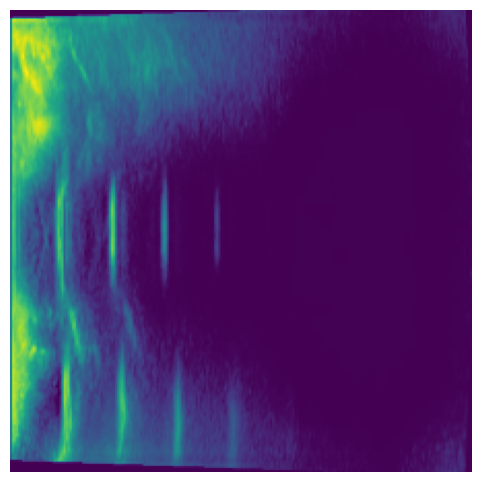

In [4]:
# load an image
from monai.utils.misc import first
from monai.data import DataLoader
path = "/data/barry.ravichandran/Pretrain_data/preprocessed_resized_224_butterfly/ONUS-001HV/018fb90d13929226c456edd05134640b1f886b80-0-burned_in.mha"
train_files = [{"image": path}]
img = setup_training_vfold(train_files,3)
train_loader = DataLoader(
        img,
        batch_size=1,
        shuffle=False,
        num_workers=1
        # pin_memory=args.pin_mem,
        # drop_last=True
    )
img = first(train_loader)
# img = img.resize((224, 224))
img = img["image"][0,:,:,:]
# img = np.array(img)
img = np.transpose(img,[1,2,0])
# img = np.array(img) / 255.
print(np.min(img),np.max(img))
assert img.shape == (224, 224,6)

# normalize by ImageNet mean and std
# img = img - imagenet_mean
# img = img / imagenet_std

plt.rcParams['figure.figsize'] = [6, 6]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [5]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = '/data/barry.ravichandran/repos/mae/output_dir/checkpoint-100.pth' #'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:
torch.Size([1, 224, 224, 6]) torch.Size([1, 224, 224, 6])


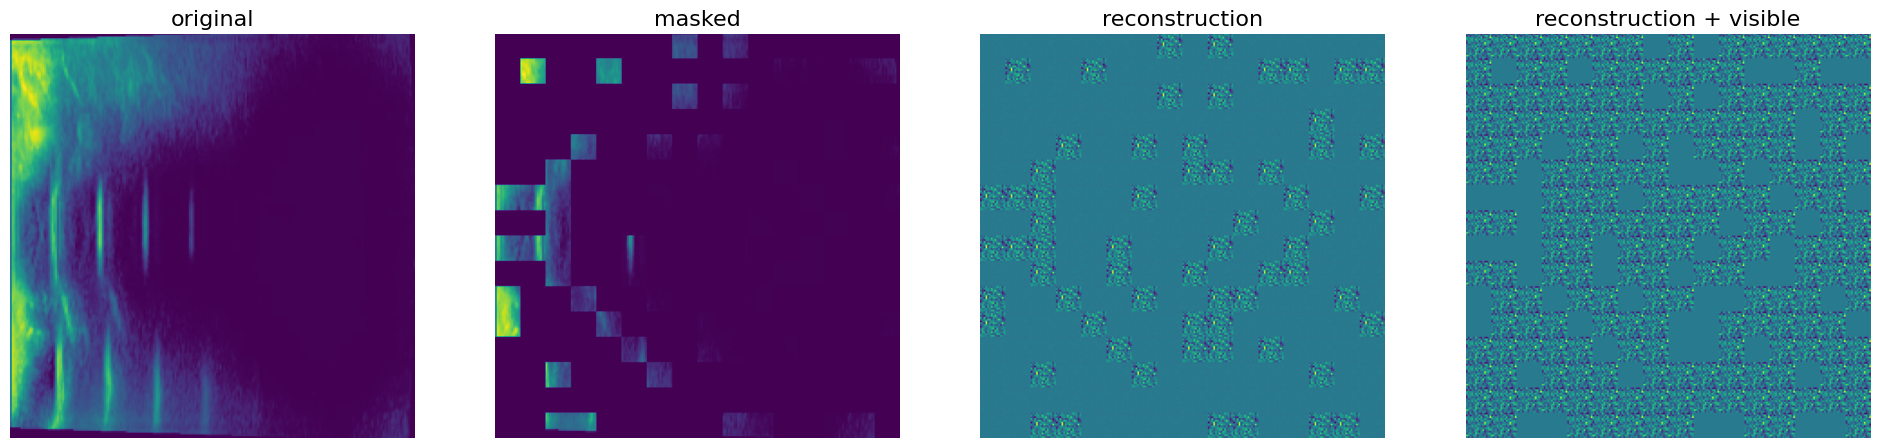

In [8]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)